# Time Series and Forecasting Models: ARIMA 

## 1. Introduction

A time series is basically a series of data points ordered in time and is an important factor in predicting stock market trends. In time series forecasting models, time is the independent variable and the goal is to predict future values based on previously observed values. 

There are many ways to model a time series in order to make predictions including Moving Averages MA(q), Autoregression AR(p), and combining these to create ARMA(p,q), ARIMA(p,q,d), SARIMA(p,q,d)(P,Q,D,s) models.

Here we will focus on the AutoRegressive Integrated Moving Average (ARIMA) model.

## 2. Install/import libraries

In [ ]:

!pip install mplfinance
!pip install pmdarima

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns

from scipy import stats
from scipy.stats import zscore

from pmdarima.arima.utils import ndiffs

import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import coint
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_predict

from itertools import product
from tqdm.notebook import tqdm

import datetime
from datetime import date, timedelta

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

## 3. Import data

In [63]:
# Create dataframe of AZN.L stock data
azn = yf.download("AZN.L", start="2013-01-01", end="2023-10-10")[['Adj Close','Open', 'High', 'Low', 'Close', 'Volume']].round(2)
azn.head()

[*********************100%%**********************]  1 of 1 completed


,Adj Close,Open,High,Low,Close,Volume
Date,,,,,,
2013-01-02,1974.84,2930.0,2969.30,2923.00,2969.0,2394731
2013-01-03,1982.16,2969.5,2982.50,2952.50,2980.0,1763172
2013-01-04,1995.46,2992.5,3005.00,2975.21,3000.0,2041101
2013-01-07,1985.48,2998.5,3004.99,2976.00,2985.0,1185261
2013-01-08,1995.46,2986.5,3005.50,2958.50,3000.0,2723178


In [64]:
# Create Dataframe for Adjusted Close prices

azn_adj = azn[['Adj Close']].copy()
azn_adj.head()

,Adj Close
Date,
2013-01-02,1974.84
2013-01-03,1982.16
2013-01-04,1995.46
2013-01-07,1985.48
2013-01-08,1995.46


In [68]:
# Plot Adjusted Close price
def azn_adj_plot(label_txt, title_txt):
    sns.set(rc={'figure.figsize':(16, 8)})
    azn_adj.plot(label=f"{label_txt}")
    plt.title(f"{title_txt}", color = 'black', fontsize = 20)
    plt.xlabel('Date', color = 'black', fontsize = 15)
    plt.ylabel('Stock Price (p)', color = 'black', fontsize = 15)
    plt.legend()

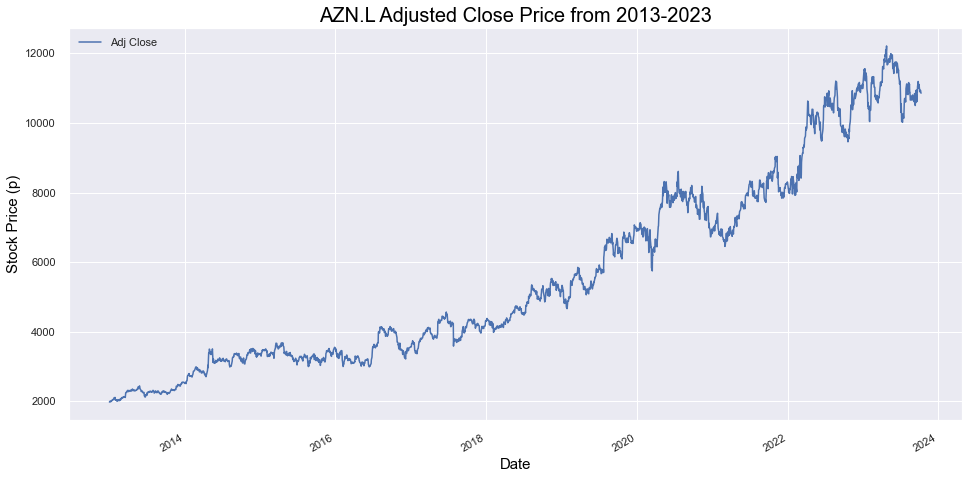

In [69]:
title_txt = "AZN.L Adjusted Close Price from 2013-2023"
label_txt = "AZN.L Adj Close"
azn_adj_plot(label_txt, title_txt)

## 4. Seasonality

Seasonality in time series data refers to period fluctuations or cyclical patterns. Differencing can be used to check for seasonality.

In [70]:
# Plot Adjusted Close price and price after differencing by one year
# removing the first year as it's NaN

year_diff = azn_adj.diff(periods=365)[365:]
"""
plt.figure(figsize=(17, 8))
plt.plot(year_diff.index, year_diff , label='Year differenced')
plt.plot(azn.index, azn['Adj Close'], label='Standard')
plt.title("Differencing to check for seasonality", color = 'black', fontsize = 20)
plt.xlabel('Year', color = 'black', fontsize = 15)
plt.ylabel('Stock Price (p)', color = 'black', fontsize = 15)
plt.grid(True)
plt.legend()
"""
year_diff.head()

,Adj Close
Date,
2014-06-13,1209.31
2014-06-16,1182.39
2014-06-17,1174.89
2014-06-18,1206.30
2014-06-19,1231.53


The difference transform does not appear to show a less volatile time series so a strong seasonal trend is unlikely. Seasonality can also be derived from an autocorrelation plot.

## 5. Stationarity

A time series is said to be stationary if its statistical properties do not change over time. In other words, it has constant mean and variance, and covariance is independent of time. Stock prices are often non-stationary and may contain trends or volatility but different transformations can be made to turn the time series into a stationary process so that it can be modelled.



### 5.1 Augmented Dickey-Fuller (ADF) test

Augmented Dickey-Fuller is the statistical test that we run to determine if a time series is stationary or not. It tests the null hypothesis ($H_{0}$) that a unit root is present in an autoregressive model. If it is, then p > 0, and the null hypothesis that the process is not stationary is true.

Otherwise, p = 0, the null hypothesis is rejected, and the process is considered to be stationary. The alternate hypothesis ($H_{1}$) that the data is stationary is accepted. 

In [71]:
# ADF Test to check if price series is stationary

result = adfuller(azn_adj.dropna())
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -0.3101085274530953
p-value: 0.9240604105747474
Critial Values:
   1%, -3.432757313106893
Critial Values:
   5%, -2.862603575802172
Critial Values:
   10%, -2.567336176204636


The p-value is greater than the significance level of 0.05 and the ADF statistic is higher than any of the critical values, therefore the series is non-stationary. The next step is to determine the order of differencing required to make the series stationary.

### 5.2 Autocorrelation Function (ACF)

Autocorrelation is the similarity between observations as a function of the time lag between them. The ACF plot, or correlogram, will tell us the order of differencing required to remove any autocorrelation in the series.

Autocorrelation is the similarity between observations of the same series at previous times as a function of the time lag between them.




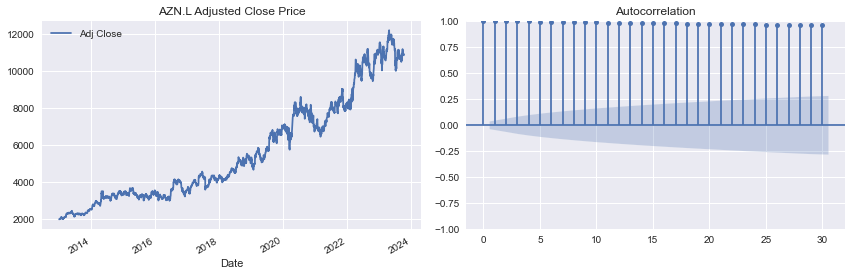

In [72]:
# Plot stock price and ACF plot

def ts_acf(y, lags=None, figsize=(12, 4)):
    plt.style.use('seaborn')
    fig = plt.figure(figsize=figsize)
    layout = (1,2)
    ts_ax = plt.subplot2grid(layout, (0,0))
    acf_ax = plt.subplot2grid(layout, (0,1))

    y.plot(ax=ts_ax)
    ts_ax.set_title('AZN.L Adjusted Close Price')
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    plt.tight_layout()
        
ts_acf(azn_adj, lags=30)

The above plots show the original price series and the autocorrelation. There is high autocorrelation, and no clear seasonality. 

## 6. Differencing (d)

The purpose of differencing it to make the time series stationary. The parameter **d** is the order of differencing required to achieve this.  In stationary time series d would be 0 but we need to find the order appropriate to our time series. 

It is the order of Integration (the (I)ntegrated In ARIMA).

### 6.1 Difference once

To get rid of the high autocorrelation and to make the process stationary, we will take the first difference and subtract the time series from itself with a lag of one day (previous value from the current value) to get the returns of the Adjusted Close price. 


In [73]:
# Calculate the first differences of the series by comparing with the element in the previous row 
# and drop NaNs
diff1 = azn_adj.diff().dropna()

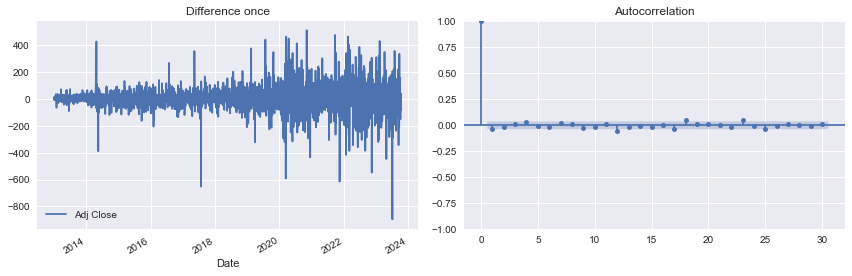

In [74]:
# Plot first order of differencing and ACF plot

def diff1_plot(y, lags=None, figsize=(12, 4)):
    plt.style.use('seaborn')
    fig = plt.figure(figsize=figsize)
    layout = (1,2)
    ax1 = plt.subplot2grid(layout, (0,0))
    acf_ax = plt.subplot2grid(layout, (0,1))

    y.plot(ax=ax1)
    ax1.set_title('Difference once')
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    plt.tight_layout()
        
diff1_plot(diff1, lags=30)

We can see that the returns randomly distribute around the mean of 0.

### 6.2 Difference twice

Differencing once might not be enough to make the series stationary which may require multiple orders of differencing. We will difference twice, or take the returns of the returns.

In [75]:
# Calculate the second order of differencing and drop NaNs
diff2 = azn_adj.diff().diff().dropna()

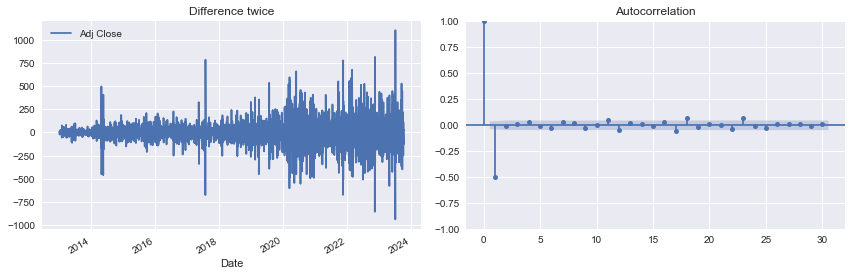

In [76]:
# Plot second order of differencing and ACF plot

def diff2_plot(y, lags=None, figsize=(12, 4)):
    plt.style.use('seaborn')
    fig = plt.figure(figsize=figsize)
    layout = (1,2)
    ax1 = plt.subplot2grid(layout, (0,0))
    acf_ax = plt.subplot2grid(layout, (0,1))

    y.plot(ax=ax1)
    ax1.set_title('Difference twice')
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    plt.tight_layout()
        
diff2_plot(diff2, lags=30)

The lag in second order of differencing goes into the far negative which indicates it might have been overdifferenced, so we will choose the order of differencing as 1.

We can also use ndiffs in the **pmdarima** package to get the order of differencing.

In [77]:
ndiffs(azn_adj, test="adf")

1

The differencing required to make the time series stationary is 1.

## 7. Auto Regressive (AR) term (p)

Auto regression is a regression of the time series with itself. We try to find out how correlated the current value is to its previous values with some lag. The parameter **p** represents the maximum lag which is found by looking at the Partial Autocorrelation plot to identify the lag after which most lags are not significant. 

### 7.1 Partial Autocorrelation Function (PACF)

The PACF plot is useful for determining the order of an AR(p) process. It only describes the direct relationship between an observation and its lag. This would suggest that there would be no correlation for lag values beyond the maximum lag.

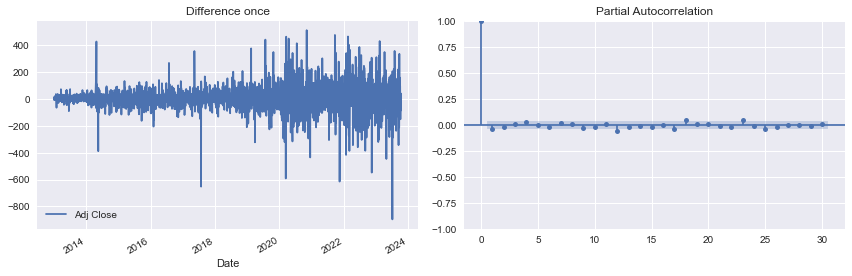

In [78]:
# Plot first order of differencing and PACF plot

def pacf_plot(y, lags=None, figsize=(12, 4)):
    plt.style.use('seaborn')
    fig = plt.figure(figsize=figsize)
    layout = (1,2)
    ax1 = plt.subplot2grid(layout, (0,0))
    pacf_ax = plt.subplot2grid(layout, (0,1))

    y.plot(ax=ax1)
    ax1.set_title('Difference once')
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
    plt.tight_layout()
        
pacf_plot(diff1, lags=30)

The PACF lag of 3 is above the significance line after which the PACF coefficients are not significant anymore. Therefore,
we will assume an autoregressive process of order 3.


## 8. Moving Average (MA) term (q)


The Moving Average term, represented by the parameter **q**, refers to the number of lagged forecast errors used to predict future values. It is used to reduce noise in a model or smooth it out. The longer the moving average period, the more smoothed out the noise would be. 

An ACF plot is used to identify the correct q value.

### 8.1 Autocorrelation function (ACF)

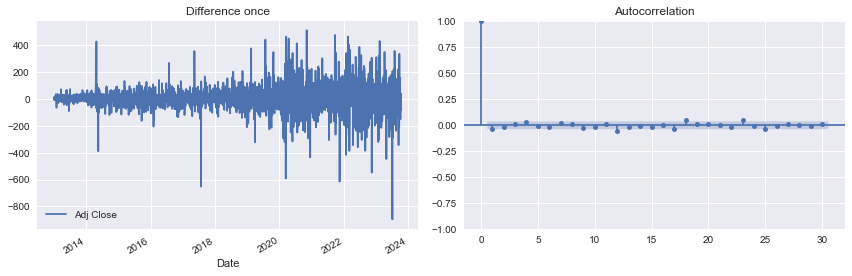

In [79]:
# Plot ACF to find q term for number of lagged forecast errors

def diff1_plot(y, lags=None, figsize=(12, 4)):
    plt.style.use('seaborn')
    fig = plt.figure(figsize=figsize)
    layout = (1,2)
    ax1 = plt.subplot2grid(layout, (0,0))
    acf_ax = plt.subplot2grid(layout, (0,1))

    y.plot(ax=ax1)
    ax1.set_title('Difference once')
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    plt.tight_layout()
        
diff1_plot(diff1, lags=30)

The ACF plot forecast error 3 is above the significance line and represents the biggest lag after which other lags are not significant.

## 9. Run ADF test on differenced time series

In [80]:
# ADF test to check if price series is now stationary

result2 = adfuller(diff1)
print(f'ADF Statistic: {result2[0]}')
print(f'p-value: {result2[1]}')
for key, value in result2[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -54.053123624969714
p-value: 0.0
Critial Values:
   1%, -3.432757313106893
Critial Values:
   5%, -2.862603575802172
Critial Values:
   10%, -2.567336176204636


The p-value is 0, less than the significance level of 0.05 and the ADF statistic is lower than all of the critical values. The null hypothesis is rejected, and the process is considered to be stationary.

## 10. Modelling

### 10.1 Fitting the ARIMA model

We will now fit the ARIMA model with the (p, d, q) terms of order (3, 1, 3) observed manually from differencing, ACF and PACF plots.

In [81]:
# Fit ARIMA model with (p, d, q) terms

model = ARIMA(azn_adj, order=(3, 1, 3))
result = model.fit()
print(result.summary())

                               SARIMAX Results                                
Dep. Variable:              Adj Close   No. Observations:                 2721
Model:                 ARIMA(3, 1, 3)   Log Likelihood              -16229.092
Date:                Tue, 14 Nov 2023   AIC                          32472.185
Time:                        01:52:57   BIC                          32513.543
Sample:                             0   HQIC                         32487.136
                               - 2721                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3708      0.513     -0.723      0.470      -1.376       0.634
ar.L2         -0.9627      0.106     -9.098      0.000      -1.170      -0.755
ar.L3         -0.1452      0.478     -0.304      0.7

We can see from the results summary that there are three AR terms and three MA terms, which are the coefficents for the linear regression, and the p-value for each of them. If any of the coefficients were very close to zero, and the p-value very high, we could remove that term. The p-value needs to be low for the terms to be important for our regression model.

### 10.2 Grid search to select the best order for ARIMA model

In order to optimise our model, for each combination of parameters we fit an ARIMA model with the SARIMAX() function and assess its overall performance. This will result in a dataframe listing the orders and corresponding Akaike’s Information Criterion (AIC) with best models in descending order.

In [84]:
def optimise_ARIMA(order_list, exog):
    """
    Optimise ARIMA model
    
    :param order_list: list with (p, d, q) tuples
    :param exog: the exogenous variable

    :return: dataframe with parameters and corresponding AIC 
    """
    results = []

    for order in order_list:
        try:
            model = SARIMAX(exog, order = order).fit()
        except:
            continue
        aic = model.aic
        results.append([order, model.aic])

    result_df = pd.DataFrame(results)
    result_df.columns = ['(p, d, q)', 'AIC']
    # Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)

    return result_df

### 10.3 Parameters to iterate through

In [85]:
# Parameters to iterate through
ps = range(0, 8, 1)
d = 1
qs = range(0, 8, 1)

# Create a list with all possible combination of parameters
parameters = product(ps, qs)
parameters_list = list(parameters)

order_list = []

for each in parameters_list:
    each = list(each)
    each.insert(1, 1)
    each = tuple(each)
    order_list.append(each)

### 10.4 Search for optimum parameters

In [87]:
result_df = optimise_ARIMA(order_list, exog=azn_adj['Adj Close'])

In [88]:
# Print dataframe of results
result_df.head()

,"(p, d, q)",AIC
0,"(2, 1, 3)",32470.833458
1,"(3, 1, 2)",32471.447832
2,"(4, 1, 2)",32471.482140
3,"(2, 1, 4)",32472.063138
4,"(3, 1, 3)",32472.184669


The order associated with the lowest AIC is (2,1,3). Therefore, this suggests an ARIMA model with an AR(2) process and an MA(3) process.

### 10.5 Fitting the best ARIMA model after Grid Search

In [89]:
# Fit and print a summary of the best model, which is ARIMA (2, 1, 3)

best_model = ARIMA(azn_adj, order=(2, 1, 3)).fit()
print(best_model.summary())

                               SARIMAX Results                                
Dep. Variable:              Adj Close   No. Observations:                 2721
Model:                 ARIMA(2, 1, 3)   Log Likelihood              -16229.417
Date:                Tue, 14 Nov 2023   AIC                          32470.833
Time:                        01:56:50   BIC                          32506.284
Sample:                             0   HQIC                         32483.649
                               - 2721                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1851      0.067     -2.771      0.006      -0.316      -0.054
ar.L2         -0.8825      0.062    -14.315      0.000      -1.003      -0.762
ma.L1          0.1496      0.069      2.162      0.0

## 12. Predictions

### Plot actual vs predicted result


'\nbest_model.plot_predict(\n      start=2391,\n      end=2517,\n      dynamic=False,\n);\n'

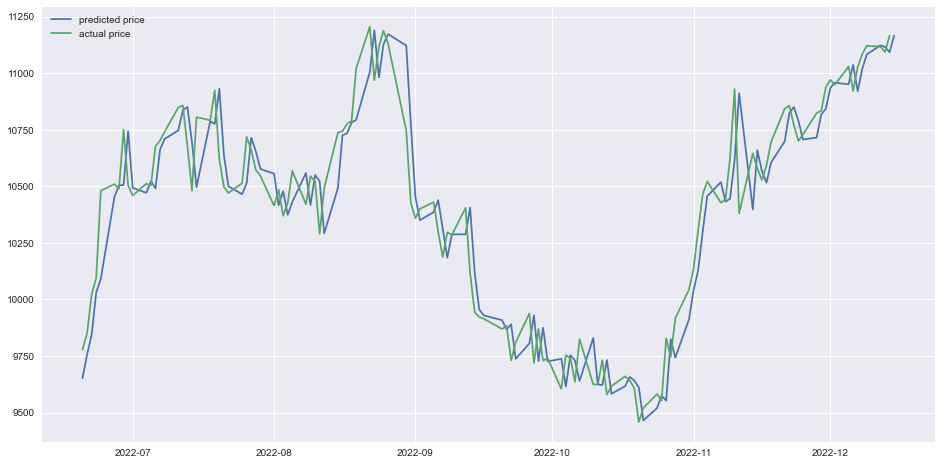

In [92]:
# Plot Actual vs predicted price for last 6 months of 2019

plt.rc("figure", figsize=(16,8))

y_actual = azn_adj.iloc[2391: 2517]
y_pred = best_model.predict(start = 2391, end = 2517, dynamic = False)
# print(y_pred, y_actual)

plt.plot(y_pred, label = "predicted price")
plt.plot(y_actual, label = "actual price")
plt.legend()
# plt.plot(y)
# plot_predict(best_model, start = 2391, end = 2517, dynamic = False)
# plt.plot(range(2391, 2517), y)
"""
best_model.plot_predict(
      start=2391,
      end=2517,
      dynamic=False,
);
"""

Our predictions are very close to our actual values so our ARIMA model is fitted correctly.